# 1. With Human Preferences

In [101]:
import warnings
warnings.filterwarnings("ignore")

In [123]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import layers
import random
import matplotlib.pyplot as plt
import pandas as pd

In [103]:
import gym

env = gym.make('CartPole-v0')

In [104]:
class Actor(tf.keras.Model): # Agent function (our model)
    def __init__(self, num_actions, num_hidden_units):
        super().__init__()
        
        self.shared_1 = layers.Dense(num_hidden_units, activation = 'relu')
        self.actor = layers.Dense(num_actions)
        
    def call(self, input_obs):
        x = self.shared_1(input_obs)
        return self.actor(x)
    
model = Actor(num_actions=2, num_hidden_units=128)

This code defines a class **Actor** that represents an agent in reinforcement learning using a neural network model. The class is a subclass of **tf.keras.Model** and uses the **tf.keras** library, which is a high-level API for building and training deep learning models.

The class has two class variables:

- **shared_1**: a dense layer with **num_hidden_units** number of neurons and the activation function **'relu'** (rectified linear unit).
- **actor**: a dense layer with **num_actions** number of neurons, representing the actions the agent can take in the environment.

The **call** method takes in an input **input_obs** (representing the state of the environment), applies the shared dense layer to the input, and returns the output from the actor dense layer.

Finally, an instance of the class **Actor** is created by calling **model = Actor(num_actions=2, num_hidden_units=128)**, where **num_actions=2** and **num_hidden_units=128** are the number of actions the agent can take and the number of hidden units in the shared dense layer, respectively.

In [105]:
obs = env.reset()[0]
action_probs_list = []
rewards = []
done = False
obs = tf.expand_dims(obs, 0)
while True:
    if done:
        break
    # run model to get action logits and value
    action_logits = model(obs)
    # categorical probabilistic action idx selection
    discrete_distribution = tfp.distributions.Categorical(action_logits)
    selection_action_idx = discrete_distribution.sample()

    action = int(selection_action_idx.numpy()[0])

    new_obs = env.step(action)[0]
    reward = env.step(action)[1]
    done = env.step(action)[2]

    human_preference_reward = ask_human_preference(obs.numpy(), action, new_obs)
    print('yes')
    reward += human_preference_reward

    action_probs = discrete_distribution.prob(selection_action_idx)
    action_probs_list.append(action_probs)
    rewards.append(reward)

KeyboardInterrupt: Interrupted by user

In [106]:
def ask_human_preference(state, action, next_state):
    """
    Asks the human for their preference between the current action and a random alternative action.
    Returns the reward based on the human's preference.
    """
    current_reward = int(input(f"Do you prefer action {action} leading to {next_state} over a random action? (1 for Yes, 0 for No): "))
    random_action = random.choice([a for a in range(env.action_space.n) if a != action])
    random_next_state = env.step(random_action)[0]
    alternative_reward = int(input(f"Do you prefer action {random_action} leading to {random_next_state} over action {action} leading to {next_state}? (1 for Yes, 0 for No): "))
    return current_reward - alternative_reward

In [107]:
def step_episode(env, model):
    obs = env.reset()[0]
    action_probs_list = []
    rewards = []
    done = False
    obs = tf.expand_dims(obs, 0)
    while True:
        if done:
            break
        # run model to get action logits and value
        action_logits = model(obs)
        # categorical probabilistic action idx selection
        discrete_distribution = tfp.distributions.Categorical(action_logits)
        selection_action_idx = discrete_distribution.sample()
        
        action = int(selection_action_idx.numpy()[0])
        new_obs = env.step(action)[0]
        reward = env.step(action)[1]
        done = env.step(action)[2]
        #print(done)
        #human_preference_reward = ask_human_preference(obs.numpy(), action, new_obs)
        #print('yes')
        #reward += human_preference_reward
        
        action_probs = discrete_distribution.prob(selection_action_idx)
        action_probs_list.append(action_probs)
        rewards.append(reward)
        obs = tf.expand_dims(new_obs, 0)
    human_preference_reward = ask_human_preference(obs.numpy(), action, new_obs)
    rewards[-1]=human_preference_reward
    env.close()
    return action_probs_list, rewards

This code defines a function **step_episode** that runs a single episode of an environment with a given agent (**model**).

The function takes two inputs:

- **env**: the environment the agent interacts with
- **model**: the agent (**Actor** model)

The function returns two outputs:

- **action_probs_list**: a list of probability distribution of actions taken by the agent at each time step of the episode
- **rewards**: a list of rewards collected by the agent at each time step of the episode

The episode starts by resetting the environment and initializing some variables (**obs**, **action_probs_list**, **rewards**, and **done**). The function then enters a while loop and continues until the **done** flag is set (indicating that the episode has terminated).

At each time step, the function:

- Expands the current observation **obs** into a batch of size 1 (using **tf.expand_dims(obs, 0)**)
- Runs the model (**Actor**) on the observation to get the action logits (**action_logits**)
- Samples a categorical action index **selection_action_idx** using the logits as input to the Categorical distribution
- Steps the environment using the selected action index (**env.step(selection_action_idx.numpy()[0])**) to get the new **observation**, **reward**, and **done** flag
- Calculates the action probability using the Categorical distribution **action_probs = discrete_distribution.prob(selection_action_idx)**
- Appends the action probability and reward to their respective lists (**action_probs_list** and **rewards**)
- Finally, the function closes the environment and returns the **action_probs_list** and **rewards** lists.

In [108]:
def calc_g(reward_trajectory, gamma):
    ez_discount = np.array([gamma**n for n in range(len(reward_trajectory))])
    gs = []
    reward_trajectory = np.array(reward_trajectory)
    
    for ts in range(len(reward_trajectory)):
        to_end_reward = reward_trajectory[ts:]
        eq_len_discount = ez_discount[:len(to_end_reward)]
        total_value = np.multiply(to_end_reward, eq_len_discount)
        g = sum(total_value)
        gs.append(g)
        
    return gs

This function calculates the discounted cumulative rewards (i.e. the returns) for a given reward trajectory in reinforcement learning. The function takes two inputs:

- **reward_trajectory**: a list of rewards collected in the trajectory of the agent.
- **gamma**: the discount factor used in the calculation of the return.

The function returns a list **gs** of the discounted cumulative rewards for each time step in the trajectory, with **gs[t]** being the return following time step **t**.

The calculation is done by first creating an array of discounts **ez_discount** using the formula gamma**n for n in the range **0 to len(reward_trajectory)**. Then for each time step **ts** in the **reward_trajectory**, it calculates the rewards from that time step to the end of the trajectory, and discounts each reward by the appropriate discount in **eq_len_discount**. Finally, it multiplies each reward with its corresponding discount, and sums up the result to get the return (**g**). The return is then added to the list **gs**.

In [109]:
def actor_loss_fn(action_probs, gs):
    action_log_probs = tf.math.log(action_probs)
    actor_loss = - tf.math.reduce_sum(action_log_probs * (gs))
    return actor_loss

This code defines a function **actor_loss_fn** that calculates the actor loss in reinforcement learning.

The function takes two inputs:

- **action_probs**: a list of probability distributions of actions taken by the agent at each time step of the episode
- **gs**: a list of discounted returns at each time step of the episode

The function returns the actor loss value (**actor_loss**).

The function first calculates the log probability of the actions taken by the agent (**action_log_probs**) by taking the logarithm of **action_probs**.

Then, it calculates the actor loss by performing an element-wise multiplication between **action_log_probs** and **gs** and reducing the sum of the result. The final loss value is negative to maximize the expected reward, as is common in reinforcement learning.

In [110]:
def complete_loss(action_probs, rewards):
    gs = calc_g(rewards, .99)
    actor_loss_val = actor_loss_fn(action_probs, gs)
    return actor_loss_val

This code defines a function **complete_loss** that calculates the total loss for an agent in a given episode.

The function takes two inputs:

- **action_probs**: a list of probability distribution of actions taken by the agent at each time step of the episode
- **rewards**: a list of rewards collected by the agent at each time step of the episode

The function returns the final loss value (**actor_loss_val**).

The function first calls the **calc_g** function to calculate the discounted return (**gs**) based on the rewards and the discount factor (**0.99**).

Then, it calculates the loss value (**actor_loss_val**) by calling the **actor_loss_fn** function and passing in the **action_probs** and **gs**.

In [111]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [112]:
average_reward = []
for episode in range(2000):
    with tf.GradientTape() as tape:
        action_probs, episode_rewards = step_episode(env, model)
        loss = complete_loss(action_probs, episode_rewards)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        average_reward.append(sum(episode_rewards)) # adds episode average reward
        
        if episode % 5 == 0:
            print(episode, np.mean(average_reward[-25:]))
    if np.mean(average_reward[-20:]) > 175:
        break

Do you prefer action 0 leading to [ 0.06130395  0.4391379  -0.19123808 -1.3347244 ] over a random action? (1 for Yes, 0 for No):  0
Do you prefer action 1 leading to [ 0.07612757  0.2526062  -0.25788748 -1.2478482 ] over action 0 leading to [ 0.06130395  0.4391379  -0.19123808 -1.3347244 ]? (1 for Yes, 0 for No):  0


0 9.0


Do you prefer action 0 leading to [-0.05062019 -1.4145433   0.14278352  2.165535  ] over a random action? (1 for Yes, 0 for No):  1
Do you prefer action 1 leading to [-0.14726302 -1.6139232   0.29291096  2.6295507 ] over action 0 leading to [-0.05062019 -1.4145433   0.14278352  2.165535  ]? (1 for Yes, 0 for No):  0
Do you prefer action 1 leading to [ 0.00186072  0.19027106 -0.1987237  -0.9627763 ] over a random action? (1 for Yes, 0 for No):  1
Do you prefer action 0 leading to [ 0.02510552  0.39295053 -0.27745357 -1.4552069 ] over action 1 leading to [ 0.00186072  0.19027106 -0.1987237  -0.9627763 ]? (1 for Yes, 0 for No):  0
Do you prefer action 1 leading to [-0.11770803 -1.026756    0.20149608  1.7081758 ] over a random action? (1 for Yes, 0 for No):  0
Do you prefer action 0 leading to [-0.1677887  -0.84017986  0.29081836  1.6363155 ] over action 1 leading to [-0.11770803 -1.026756    0.20149608  1.7081758 ]? (1 for Yes, 0 for No):  0
Do you prefer action 0 leading to [-0.15248846

5 6.833333333333333


KeyboardInterrupt: Interrupted by user

This code implements the training loop for an actor-critic reinforcement learning agent. The training occurs over 2000 episodes or until the average reward over the last 20 episodes is greater than 175.

For each episode:

- The **step_episode** function is called to generate a set of action probabilities and episode rewards.
- The **complete_loss** function is called to calculate the total loss for the episode, including both the actor loss and the critic loss.
- The gradient of the loss with respect to the model's trainable variables is computed with **tape.gradient**.
- The optimizer is then used to update the model's parameters.
- The episode average reward is added to a list **average_reward**.

If the episode number is divisible by 20, the mean of the last 25 average rewards is printed. If the mean average reward over the last 20 episodes is greater than 175, the training loop terminates.

# 2. Without Human Preferences

In [113]:
def step_episode_originel(env, model):
    obs = env.reset()[0]
    action_probs_list = []
    rewards = []
    done = False
    
    while True:
        if done:
            break
        obs = tf.expand_dims(obs, 0)
        # run model to get action logits and value
        action_logits = model(obs)
        # categorical probabilistic action idx selection
        discrete_distribution = tfp.distributions.Categorical(action_logits)
        selection_action_idx = discrete_distribution.sample()
        
        action = selection_action_idx.numpy()[0]
        
        obs = env.step(action)[0]
        reward = env.step(action)[1]
        done = env.step(action)[2]
        
        action_probs = discrete_distribution.prob(selection_action_idx)
        action_probs_list.append(action_probs)
        rewards.append(reward)
    env.close()
    return action_probs_list, rewards, obs, action

In [114]:
average_reward = []
for episode in range(2000):
    with tf.GradientTape() as tape:
        action_probs, episode_rewards, obs, action = step_episode_originel(env, model)
        loss = complete_loss(action_probs, episode_rewards)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        average_reward.append(sum(episode_rewards)) # adds episode average reward
        
        if episode % 50 == 0:
            print(episode, np.mean(average_reward[-25:]))
    if np.mean(average_reward[-20:]) > 175:
        break

0 3.0
50 5.2
100 6.16
150 5.72
200 5.0
250 8.12
300 10.72
350 14.4
400 8.92
450 10.88
500 14.84
550 11.28
600 20.48
650 22.24
700 25.88
750 37.2
800 31.64
850 35.68
900 32.12
950 40.04
1000 45.68
1050 55.4
1100 61.76
1150 53.52
1200 40.6
1250 72.24
1300 60.52
1350 83.76
1400 85.32
1450 73.2
1500 90.24
1550 92.08
1600 86.32
1650 122.0


In [127]:
s = pd.Series(average_reward)

# create a rolling window of size 20 and calculate the mean
rolling_mean = s.rolling(window=20, min_periods=1).mean()

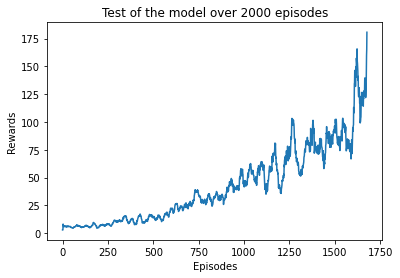

In [134]:
plt.plot(rolling_mean)
plt.title('Test of the model over 2000 episodes')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.savefig("final_plot.png")

# 3. With Human Preferences and fitting the Reward function

In [80]:
class Rewarder(tf.keras.Model): # Reward function
    def __init__(self, num_hidden_units):
        super().__init__()
        
        self.shared_1 = layers.Dense(num_hidden_units, activation = 'relu')
        self.reward = layers.Dense(1)
        
    def call(self, input_obs):
        x = self.shared_1(input_obs)
        return self.reward(x)

This code defines a class called **Rewarder** that inherits from **tf.keras.Model**, which means it is a TensorFlow Keras model. The purpose of this model is to calculate a reward value based on the input observations provided to it.

The **__init__** method of the **Rewarder** class takes one parameter **num_hidden_units**, which specifies the number of hidden units to be used in the first layer of the model. Inside this method, two layers are defined: **self.shared_1** and **self.reward**.

The first layer **self.shared_1** is an instance of the **Dense** class from the **layers** module of TensorFlow Keras. This layer has **num_hidden_units** hidden units and uses the rectified linear unit (ReLU) activation function.

The second layer **self.reward** is another instance of the **Dense** class, but with only one output unit, which represents the predicted reward value.

The **call** method of the **Rewarder** class is the method that is called when the model is run with input data. This method takes an input tensor **input_obs** as its argument and passes it through the first layer **self.shared_1** to produce an intermediate tensor **x**. The intermediate tensor **x** is then passed through the second layer **self.reward** to produce the final output tensor, which is the predicted reward value.

Overall, this code defines a simple neural network model that takes an input tensor and produces a single output value that represents the predicted reward.

In [81]:
rewarder = Rewarder(num_hidden_units=128)

In [82]:
#############################################################
def step_episode_2(env, model):
    env.reset()
    action_probs_list = []
    rewards = []
    states = []
    actions = []
    done = False
    
    while True:
        if done:
            break
        obs = tf.expand_dims(env.state, 0)
        # run model to get action logits and value
        action_logits = model(obs)
        # categorical probabilistic action idx selection
        #discrete_distribution = tfp.distributions.Categorical(action_logits)
        #selection_action_idx = discrete_distribution.sample()
        #selected_action_idx = tf.random.categorical(action_logits, 1)[0, 0]
        # categorical probabilistic action idx selection
        discrete_distribution = tfp.distributions.Categorical(action_logits)
        selection_action_idx = discrete_distribution.sample()
        
        states.append(obs)
        actions.append(int(selection_action_idx.numpy()[0]))
        
        #reward, playing = env.step(selected_action_idx)
        
        action = int(selection_action_idx.numpy()[0])
        obs = env.step(action)[0]
        reward = env.step(action)[1]
        done = env.step(action)[2]
        

        action_probs = discrete_distribution.prob(selection_action_idx)
        action_probs_list.append(action_probs)
        #action_probs = discrete_distribution.prob(selection_action_idx)
        #action_probs_list.append(probability_of_taking_selected_action)
        rewards.append(reward)
    return action_probs_list, rewards, states, actions

In [97]:
def preference_update(states, actions, rewarder):
    transition_ids = random.sample(range(0, len(states)-2), 2)
    pref = input('selected preference a:left, d:right, s:same')
    if pref == 'a':
        dist = [1,0]
    if pref == 'd':
        dist = [0,1]
    if pref == 's':
        dist = [1,1]
    
    with tf.GradientTape() as tape:
        reward1 = rewarder(states[transition_ids[0]+1])
        reward2 = rewarder(states[transition_ids[1]+1])
        p1 = tf.exp(reward1) / tf.exp(reward1) + tf.exp(reward2)
        p2 = tf.exp(reward2) / tf.exp(reward1) + tf.exp(reward2)
        loss = -tf.math.log(p1)*dist[0] + tf.math.log(p2)*dist[1]
    grads = tape.gradient(loss, rewarder.trainable_variables)
    #print('\n',len(grads),grads[0], grads[1].shape, grads[2].shape, grads[3].shape)
    #print('\n',len(rewarder.trainable_variables),rewarder.trainable_variables[0],rewarder.trainable_variables[1].shape,rewarder.trainable_variables[2].shape,rewarder.trainable_variables[3].shape)
    optimizer.apply_gradients(zip(grads, rewarder.trainable_variables))

The **preference_update** function takes three arguments: **states**, **actions**, and **rewarder**. This function updates the reward function **rewarder** based on user preferences between two randomly sampled state-action transitions.

The function first randomly selects two state-action transitions from the provided **states** and **actions** arrays using the **random.sample** function. It then prompts the user to select a preference between the two transitions, with 'a' representing a preference for the left transition, 'd' representing a preference for the right transition, and 's' representing no preference.

Based on the user's preference, the function creates a **dist** list with two elements representing the desired distribution of the reward probabilities for the two transitions.

The function then uses TensorFlow's **GradientTape** context to compute the gradients of the loss with respect to the trainable variables in the **rewarder** model. The loss is defined based on the user's preference and the predicted reward values of the two state-action transitions. The loss is then used to compute the gradients, which are used to update the **rewarder** model using the provided **optimizer**.

Overall, this code is used to update a reward function based on user preferences, with the goal of improving the performance of a reinforcement learning algorithm.

In [98]:
average_len = []
for episode in range(5000):
    with tf.GradientTape() as tape:
        action_probs, rewards, states, actions = step_episode_2(env, model)
        loss = complete_loss(action_probs, rewards)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    average_len.append(len(rewards)) # adds episode average reward

    preference_update(states, actions, rewarder)
    
    print('Episode', episode)
    
    print('Average steps to target', np.mean(average_len[-100:]))

selected preference a:left, d:right, s:same a


KeyError: 'The optimizer cannot recognize variable rewarder_1/dense_6/kernel:0. This usually means you are trying to call the optimizer to update different parts of the model separately. Please call `optimizer.build(variables)` with the full list of trainable variables before the training loop or use legacy optimizer `tf.keras.optimizers.legacy.{self.__class__.__name__}.'